In [2]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# === Load Data ===
file_path = "/Users/jasonraiti/Documents/GitHub/Open_Weather/Open_Weather/Open_Meteo/Scalable_30day/June12/precipitation_data.csv"
df_raw = pd.read_csv(file_path)


In [3]:
df = df_raw.copy()

# === Strip whitespace and preview columns ===
df.columns = df.columns.str.strip()

# === Keep original values for inspection ===
df['precip_mm_raw'] = df['precip_mm']

# === Coerce precip_mm to numeric, catching problems ===
df['precip_mm'] = pd.to_numeric(df['precip_mm'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === Ensure coordinates are numeric for validation ===
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# === Identify Problems ===
problem_precip = df[df['precip_mm'].isna() & df['precip_mm_raw'].notna()]
negative_precip = df[df['precip_mm'] < 0]
missing_dates = df[df['date'].isna()]
weird_coords = df[(df['latitude'].abs() > 90) | (df['longitude'].abs() > 180)]

# === Print Suspicious Rows ===
print("\n⚠️ Non-numeric or malformed 'precip_mm' values:")
print(problem_precip[['taxa_name', 'date', 'precip_mm_raw']].head(10))

print("\n⚠️ Negative 'precip_mm' values:")
print(negative_precip[['taxa_name', 'date', 'precip_mm']].head(10))

print("\n⚠️ Malformed or missing 'date' values:")
print(missing_dates[['taxa_name', 'date', 'precip_mm']].head(10))

print("\n⚠️ Suspicious latitude/longitude values:")
print(weird_coords[['taxa_name', 'latitude', 'longitude']].head(10))

# === Optional: Export all problematic rows for review ===
problem_rows = pd.concat([
    problem_precip,
    negative_precip,
    missing_dates,
    weird_coords
]).drop_duplicates()

problem_rows.to_csv("suspicious_entries.csv", index=False)


⚠️ Non-numeric or malformed 'precip_mm' values:
Empty DataFrame
Columns: [taxa_name, date, precip_mm_raw]
Index: []

⚠️ Negative 'precip_mm' values:
Empty DataFrame
Columns: [taxa_name, date, precip_mm]
Index: []

⚠️ Malformed or missing 'date' values:
Empty DataFrame
Columns: [taxa_name, date, precip_mm]
Index: []

⚠️ Suspicious latitude/longitude values:
Empty DataFrame
Columns: [taxa_name, latitude, longitude]
Index: []


⚠️ 0 invalid precipitation values found and set to NaN


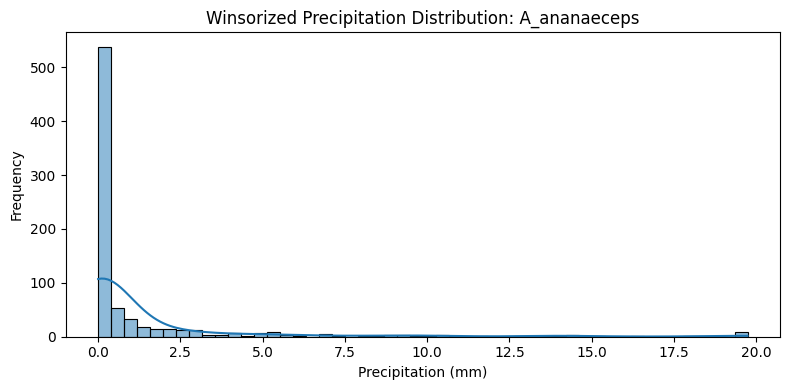

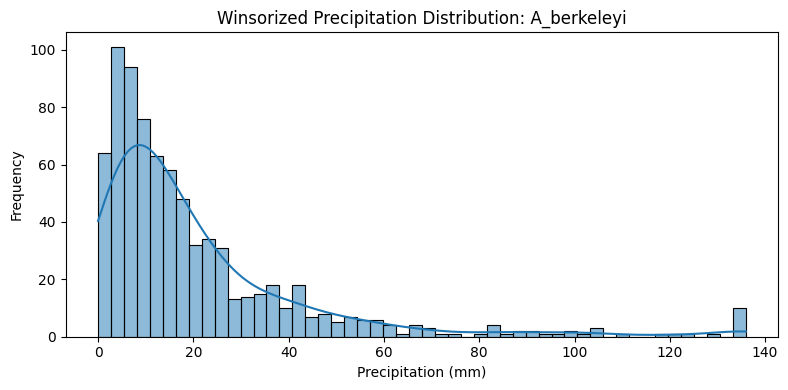

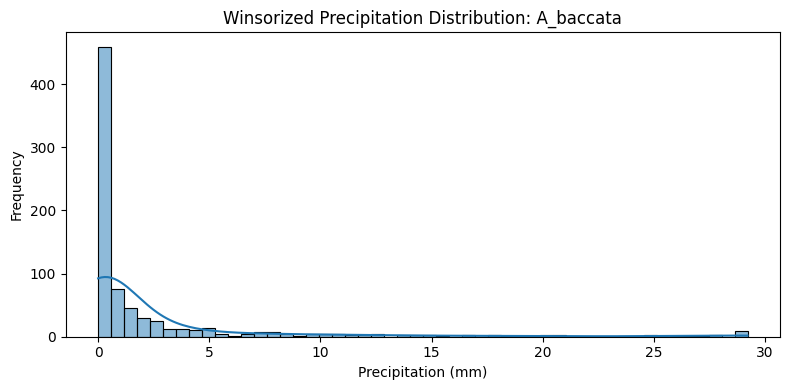

In [4]:

# === Clean Column Names ===
df.columns = df.columns.str.strip()

# === Convert `precip_mm` to numeric (force coercion) ===
df['precip_mm'] = pd.to_numeric(df['precip_mm'], errors='coerce')

# Check how many values were coerced to NaN
num_invalid = df['precip_mm'].isna().sum()
print(f"⚠️ {num_invalid} invalid precipitation values found and set to NaN")

# === Convert `date` to datetime ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === Winsorize Precipitation Per Taxa (99th percentiles) ===
def upper_winsorize_series(x, upper=0.99):
    q_high = x.quantile(upper)
    return x.clip(upper=q_high)

df['precip_mm_winsor'] = df.groupby('taxa_name')['precip_mm'].transform(upper_winsorize_series)

# === Summary Statistics by Taxa ===
summary_stats = df.groupby("taxa_name")["precip_mm_winsor"].agg(
    count="count",
    mean="mean",
    std="std",
    max="max",
    min="min",
    total="sum",
    zero_days=lambda x: (x == 0).sum()
).reset_index()

summary_stats.to_csv("taxa_summary_statistics_winsorized.csv", index=False)

# === Z-Score Based Outlier Detection (Winsorized) ===
df['zscore'] = df.groupby('taxa_name')['precip_mm_winsor'].transform(zscore)
df['outlier'] = df['zscore'].abs() > 3

# === Step: Flag Invalid Values ===
df['negative_precip'] = df['precip_mm'] < 0
df['missing_date'] = df['date'].isna()

# === Save Flagged Dataset ===
df.to_csv("precipitation_data_flagged_winsorized.csv", index=False)

# === Quick Visual Check ===
sample_taxa = df['taxa_name'].dropna().unique()[:3]

for taxa in sample_taxa:
    subset = df[df['taxa_name'] == taxa]
    plt.figure(figsize=(8, 4))
    sns.histplot(subset['precip_mm_winsor'].dropna(), bins=50, kde=True)
    plt.title(f"Winsorized Precipitation Distribution: {taxa}")
    plt.xlabel("Precipitation (mm)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [5]:
# Group by fruiting event (30-day period)
event_stats_df = df.groupby(['taxa_name', 'desired_end_date']).agg(
    days_in_window=('precip_mm_winsor', 'count'),
    total_precip_30d=('precip_mm_winsor', 'sum'),
    mean_precip_30d=('precip_mm_winsor', 'mean'),
    max_precip_30d=('precip_mm_winsor', 'max'),
    zero_rain_days_30d=('precip_mm_winsor', lambda x: (x == 0).sum()),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first'),
    year=('year', 'first')
).reset_index()
event_stats_df.to_csv("precipitation_data_flagged_winsorized_aggregated30d.csv", index=False)


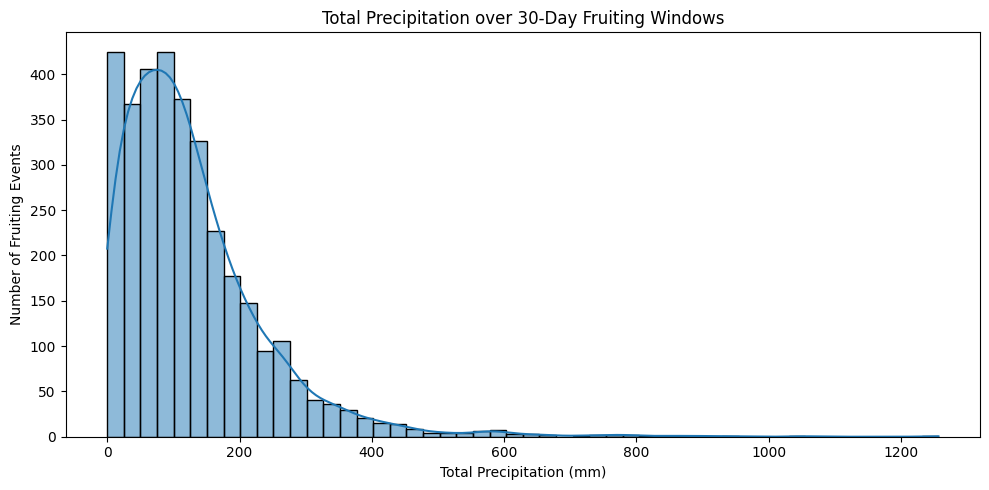

In [6]:
## 4A. Histogram of total precipitation per event
plt.figure(figsize=(10, 5))
sns.histplot(event_stats_df['total_precip_30d'], bins=50, kde=True)
plt.title("Total Precipitation over 30-Day Fruiting Windows")
plt.xlabel("Total Precipitation (mm)")
plt.ylabel("Number of Fruiting Events")
plt.tight_layout()
plt.show()

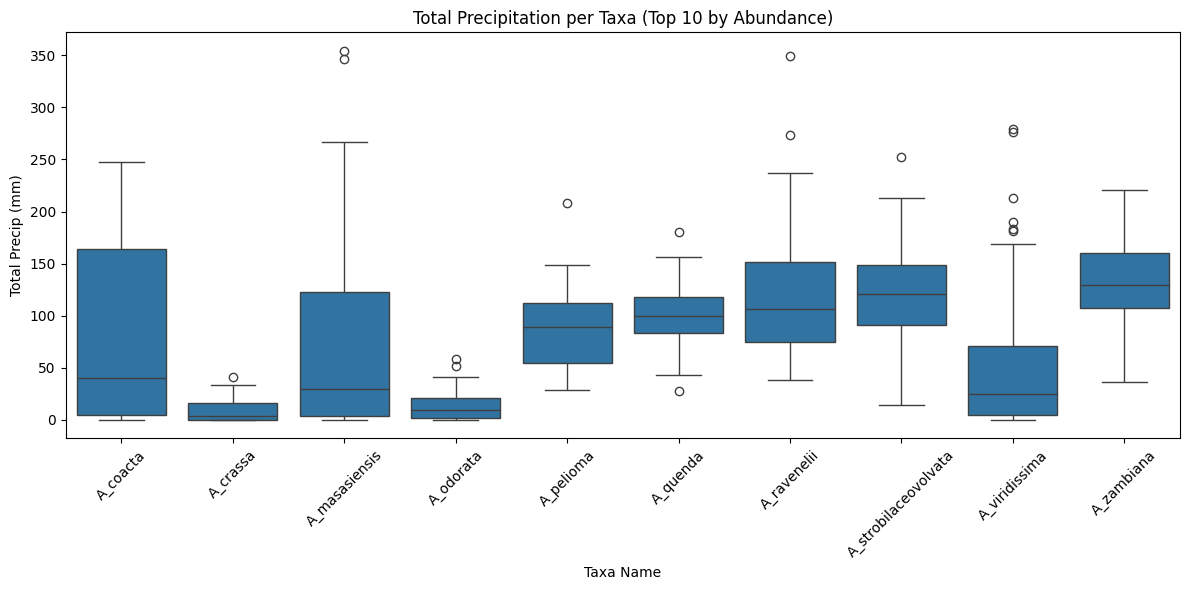

In [7]:
## 4B. Boxplot of total precipitation by taxa (top N most common)
top_taxa = event_stats_df['taxa_name'].value_counts().nlargest(10).index
filtered = event_stats_df[event_stats_df['taxa_name'].isin(top_taxa)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x='taxa_name', y='total_precip_30d')
plt.title("Total Precipitation per Taxa (Top 10 by Abundance)")
plt.ylabel("Total Precip (mm)")
plt.xlabel("Taxa Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

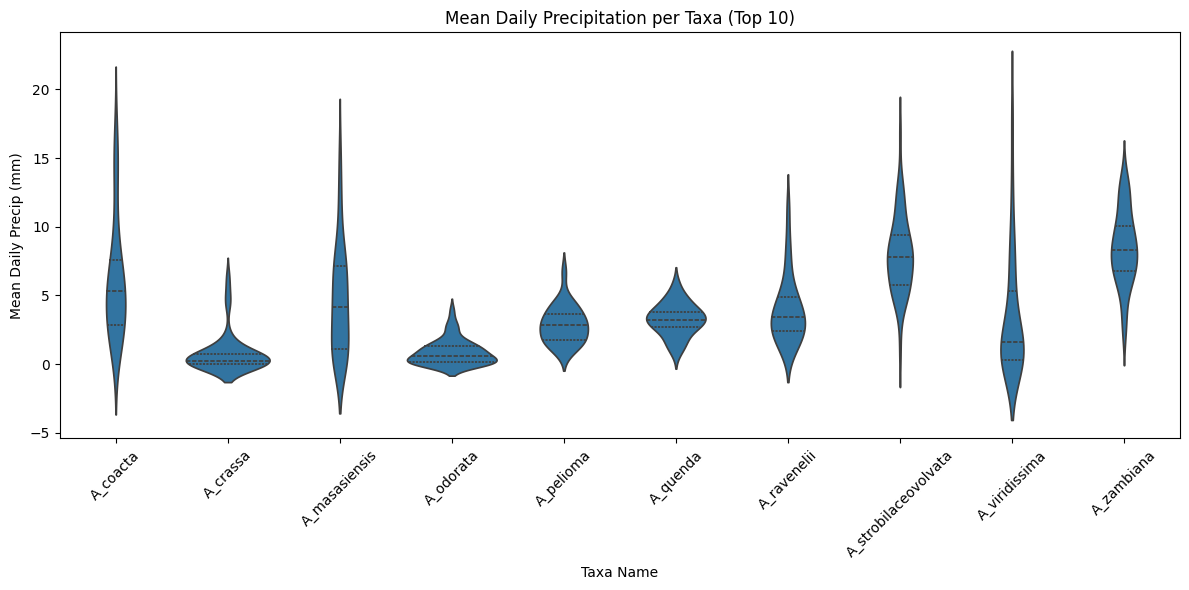

In [8]:
## 4C. Violin plot of mean daily precipitation per taxa (same taxa)
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered, x='taxa_name', y='mean_precip_30d', inner="quart")
plt.title("Mean Daily Precipitation per Taxa (Top 10)")
plt.ylabel("Mean Daily Precip (mm)")
plt.xlabel("Taxa Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Compute Z-scores per taxa for relevant metrics
event_stats_df['zscore_total_precip'] = event_stats_df.groupby('taxa_name')['total_precip_30d'].transform(zscore)
event_stats_df['zscore_mean_precip'] = event_stats_df.groupby('taxa_name')['mean_precip_30d'].transform(zscore)
event_stats_df['zscore_zero_days'] = event_stats_df.groupby('taxa_name')['zero_rain_days_30d'].transform(zscore)

# Flag unusually high or low events
event_stats_df['extreme_total_precip'] = event_stats_df['zscore_total_precip'].abs() > 3
event_stats_df['extreme_mean_precip'] = event_stats_df['zscore_mean_precip'].abs() > 3
event_stats_df['extreme_zero_days'] = event_stats_df['zscore_zero_days'].abs() > 3

# Save new dataset
event_stats_df.to_csv("aggregated_30d_with_zscores.csv", index=False)

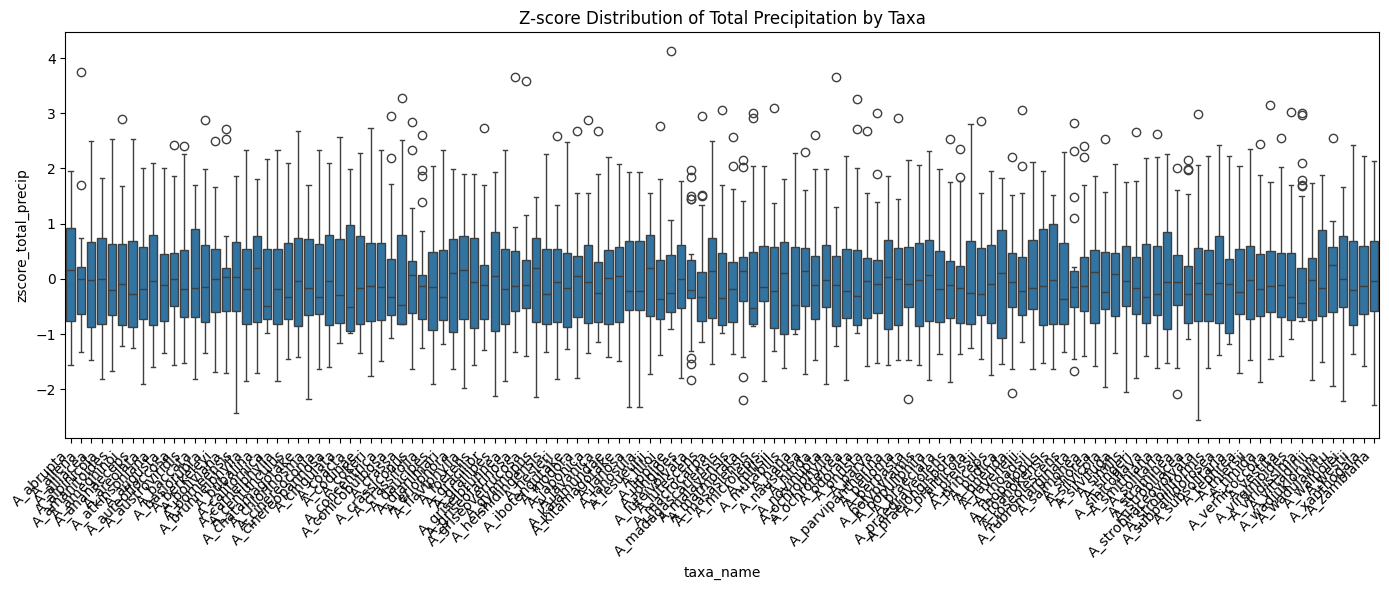

In [10]:
# === Boxplot: Z-score total precipitation by taxa ===
plt.figure(figsize=(14, 6))
sns.boxplot(data=event_stats_df, x="taxa_name", y="zscore_total_precip")
plt.xticks(rotation=45, ha='right')
plt.title("Z-score Distribution of Total Precipitation by Taxa")
plt.tight_layout()
plt.show()


/var/folders/s7/bjzn0_y50653l6wb8r4ycn2r0000gn/T/ipykernel_51915/2428086117.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


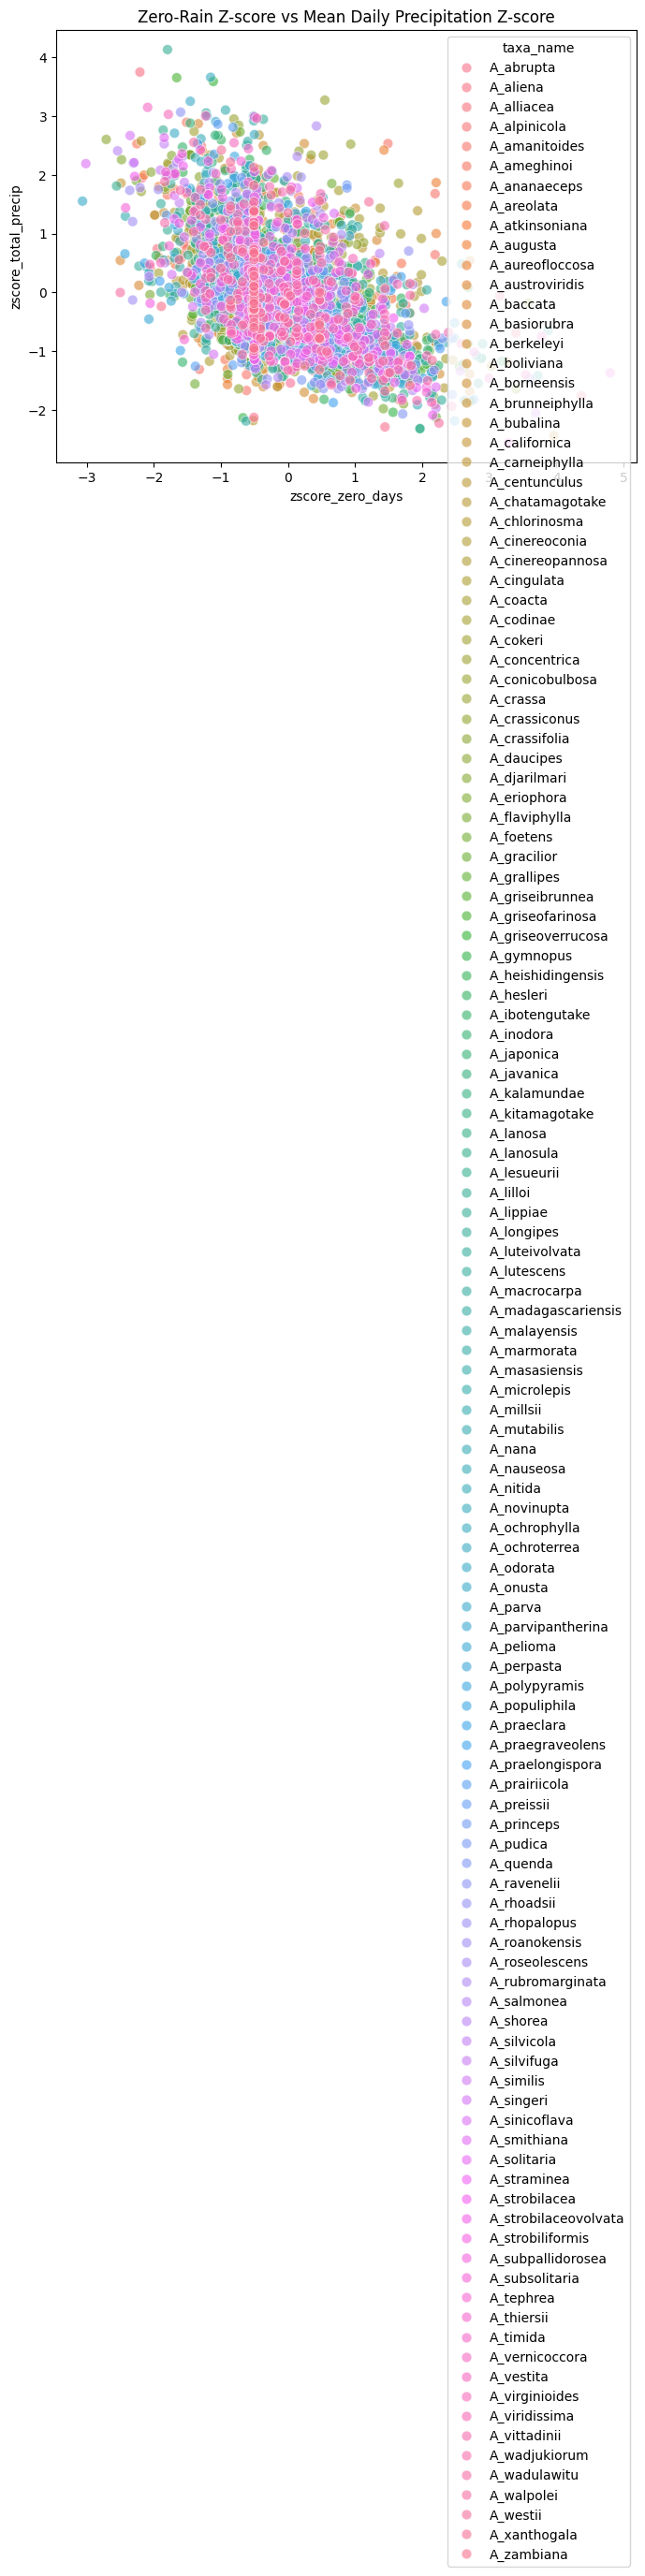

In [11]:
# === Scatterplot: Zero-rain days vs Mean precipitation Z-score ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=event_stats_df, x="zscore_zero_days", y="zscore_total_precip", hue="taxa_name", alpha=0.6, edgecolor='w', s=60)
plt.title("Zero-Rain Z-score vs Mean Daily Precipitation Z-score")
plt.tight_layout()
plt.show()

taxa_name,desired_end_date,days_in_window,total_precip_30d,mean_precip_30d,max_precip_30d,zero_rain_days_30d,latitude,longitude,year,zscore_total_precip,zscore_mean_precip,zscore_zero_days,extreme_total_precip,extreme_mean_precip,extreme_zero_days
A_aliena,2024-05-26,31,418.0679999999999,13.48606451612903,49.441999999999986,9,-30.1288,-52.0483,2024,3.7503361608698804,3.75033616086988,-2.2067719909772356,True,True,False
A_crassa,2021-12-31,28,41.2,1.4714285714285715,12.9,18,-39.1644,-66.1458,2021,3.2732597850982663,0.4690136714005625,0.5492716287305682,True,False,False
A_griseofarinosa,2020-07-30,31,649.62,20.955483870967743,61.15999999999999,1,35.0178,135.8552,2020,3.6546252567513084,3.654625256751309,-1.658241509859655,True,True,False
A_griseoverrucosa,2022-06-17,31,875.276,28.234709677419353,72.238,2,26.1548,117.382,2022,3.5904521675778147,3.5904521675778147,-1.1129977740066779,True,True,False
A_lippiae,2022-07-03,31,223.54399999999987,7.211096774193544,24.635999999999967,1,-8.592,-37.2471,2022,4.132729986793424,4.132729986793424,-1.7954219397738895,True,True,False
A_madagascariensis,2013-02-21,31,903.3,29.138709677419353,71.3,0,-19.5742,48.7032,2013,3.056059199269838,3.056059199269838,-1.2195705986919858,True,True,False
A_masasiensis,2001-01-29,29,354.32,12.217931034482758,28.05999999999999,1,-10.44564,38.481584,2001,3.0013067220043657,1.9531246778999622,-0.5109001225855497,True,False,False
A_millsii,2013-12-01,31,171.6,5.535483870967742,23.3,11,-42.1306,148.3123,2013,3.1044684199740478,3.1044684199740478,-0.9312146773814196,True,True,False
A_ochrophylla,2022-03-22,30,461.0559999999994,15.368533333333314,69.3519999999998,4,-27.4705,153.026,2022,3.6622968916602776,3.682267981664872,-1.1528858263692967,True,True,False
A_odorata,2000-12-31,15,58.911999999999985,3.9274666666666658,10.355999999999995,2,2.1701,21.4872,2000,3.253510761912049,3.3613482540402693,-1.4565070557783124,True,True,False
A_parva,2017-06-21,31,295.46799999999996,9.531225806451612,38.083999999999975,4,29.652,-82.325,2017,3.003048874771434,3.003048874771435,-1.2084142090617154,True,True,False
A_ravenelii,2018-08-13,31,349.3639999999999,11.2698064516129,43.91599999999998,5,39.0993,-76.8483,2018,3.0682179890017274,3.0682179890017274,-1.6001713541144778,True,True,False
A_vernicoccora,2005-05-21,31,253.51199999999994,8.177806451612902,32.60599999999997,8,38.7426,-120.4358,2005,3.15063459779584,3.1506345977958397,-2.091743150604225,True,True,False
A_virginioides,2021-08-30,31,426.9639999999999,13.773032258064513,70.58199999999994,3,35.0178,135.8552,2021,3.0308322913352366,3.0308322913352366,-1.7829130853093884,True,True,False
A_viridissima,2021-12-31,22,279.71999999999997,12.714545454545453,47.31999999999998,0,-12.881003,-41.373129,2021,3.0051688589400793,2.088816622169726,-1.2265798912948744,True,False,False


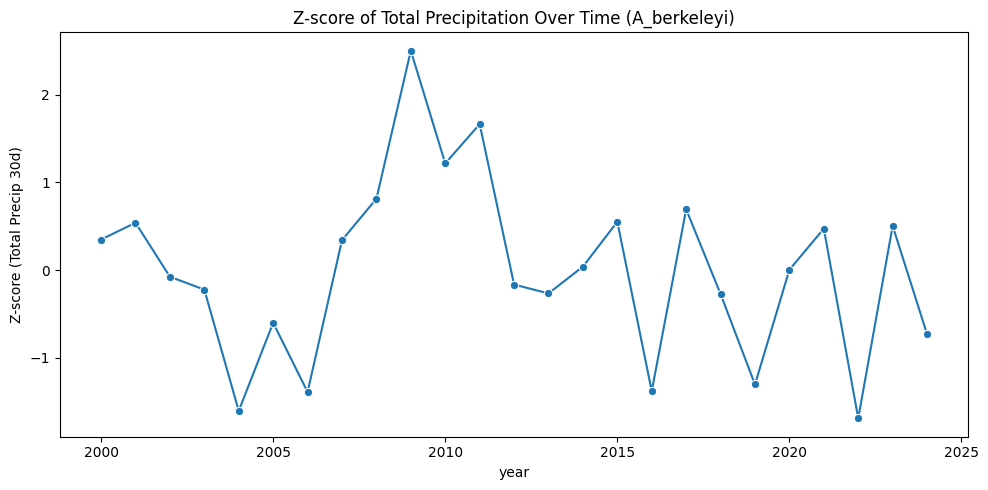

In [12]:
# === Lineplot: Z-score over time for a selected taxon ===
selected_taxon = "A_berkeleyi"  # Change as needed
taxon_subset = event_stats_df[event_stats_df["taxa_name"] == selected_taxon]
plt.figure(figsize=(10, 5))
sns.lineplot(data=taxon_subset, x="year", y="zscore_total_precip", marker="o")
plt.title(f"Z-score of Total Precipitation Over Time ({selected_taxon})")
plt.ylabel("Z-score (Total Precip 30d)")
plt.tight_layout()
plt.show()

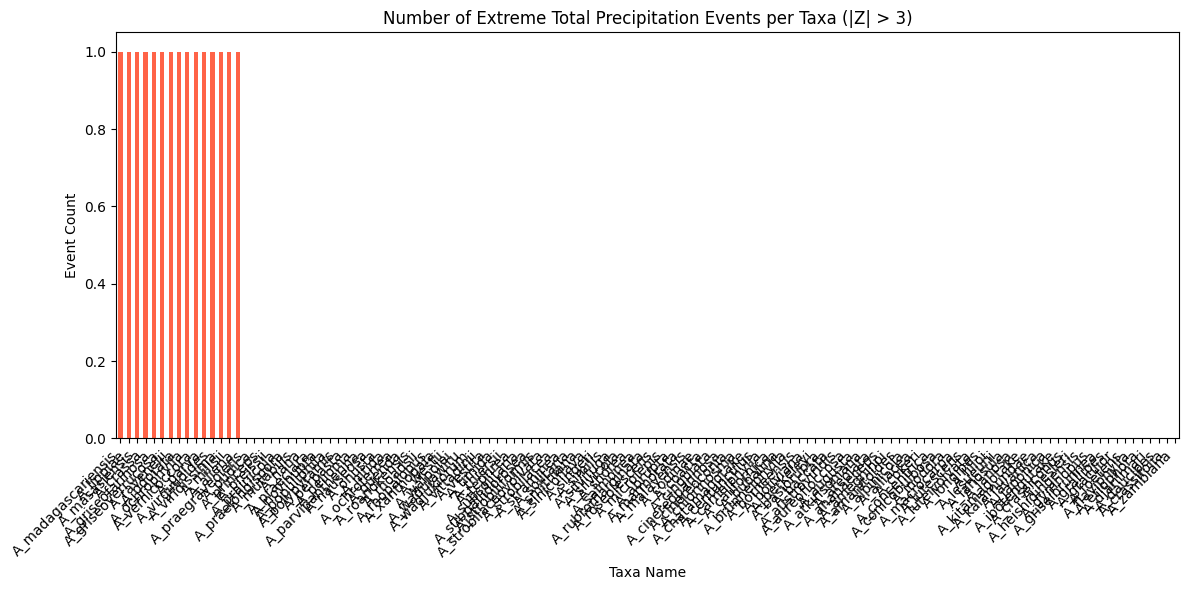

In [26]:
# === Barplot: Frequency of extreme events per taxa ===
extreme_counts = event_stats_df.groupby("taxa_name")["extreme_total_precip"].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
extreme_counts.plot(kind='bar', color='tomato')
plt.title("Number of Extreme Total Precipitation Events per Taxa (|Z| > 3)")
plt.ylabel("Event Count")
plt.xlabel("Taxa Name")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


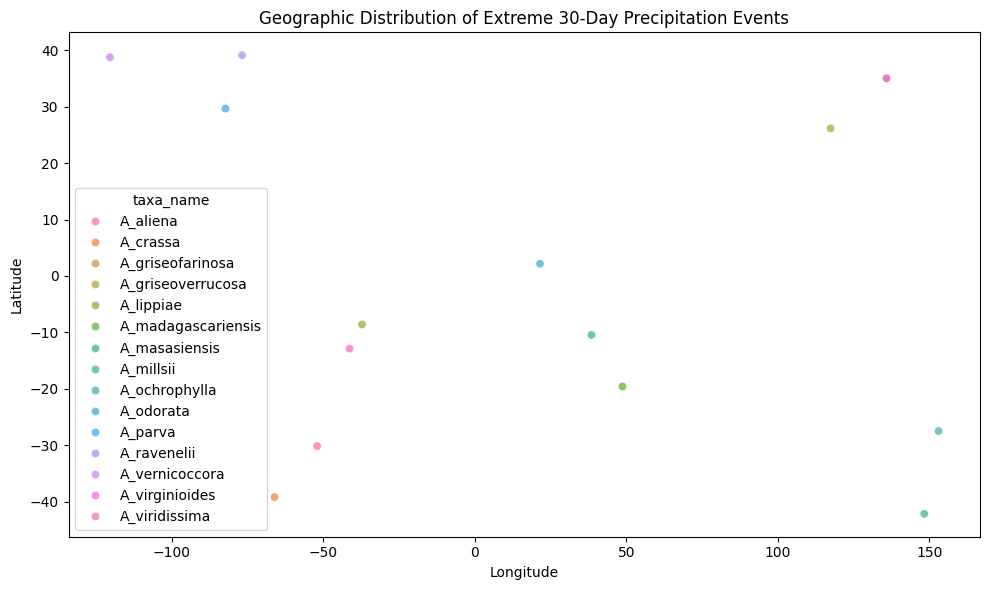

In [30]:
# === Map: Locations of extreme total precipitation events ===
extreme_events = event_stats_df[event_stats_df["extreme_total_precip"]]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=extreme_events, x="longitude", y="latitude", hue="taxa_name", alpha=0.7)
plt.title("Geographic Distribution of Extreme 30-Day Precipitation Events")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

extreme_events.to_csv("aggregated_30d_extreme_precipitation_events.csv", index=False)